## 1. Environment Setup and Imports

In [13]:
# Production Shipping Lane Discovery - Complete Pipeline
import os
import sys
import time
import logging
import yaml
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, Any

# Data science libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import h3

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import folium

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Add project root to path for imports
project_root = Path.cwd().parent
sys.path.append(str(project_root))

print(f"🚀 Production Shipping Lane Discovery")
print(f"🔧 Project root: {project_root}")
print(f"🐍 Python version: {sys.version.split()[0]}")
print(f"📅 Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Configure logging for production run
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(),
        logging.FileHandler(project_root / 'data' / 'shipping_lanes_discovery.log')
    ]
)

# Import shipping lanes discovery modules
from src.features.trajectory import (
    load_vessel_data,
    segment_into_journeys,
    journeys_to_h3_sequences,
    process_all_vessels,
    calculate_route_centroids,
    link_routes_to_terminals,
    save_route_graph_to_geopackage
)

from src.models.clustering import (
    extract_journey_endpoints,
    cluster_terminal_points,
    create_terminal_summary,
    save_terminals_to_geopackage,
    compute_dtw_distance_matrix,
    cluster_routes,
    assign_route_clusters_to_journeys
)

from src.visualization.lanes import (
    load_terminals_and_routes,
    plot_shipping_lanes_map,
    create_and_save_shipping_lanes_map
)

from src.utils.metrics import (
    calculate_clustering_metrics,
    calculate_terminal_metrics,
    calculate_route_metrics,
    log_validation_summary
)

from src.data.loader import AISDataLoader
from src.data.duckdb_engine import DuckDBEngine

print("✅ All modules imported successfully")
print("🎯 Ready for production shipping lane discovery!")

🚀 Production Shipping Lane Discovery
🔧 Project root: /home/marius/repo_linux/ais-forecasting
🐍 Python version: 3.10.18
📅 Start time: 2025-08-01 20:20:04
✅ All modules imported successfully
🎯 Ready for production shipping lane discovery!


## 2. Production Configuration

Setting up optimized parameters for real-world AIS data processing with full dataset coverage.

In [ ]:
# Create production output directory
production_output_dir = project_root / "data" / "processed" / "shipping_lanes_global"
production_output_dir.mkdir(exist_ok=True, parents=True)

# Global production configuration - optimized for worldwide terminal discovery
production_config = {
    'data': {
        'raw_data_dir': str(project_root / "data"),
        'date_range': {
            'start': '2018-01-01',  # Use all available data
            'end': '2024-12-31'
        },
        'vessel_filter': {
            'min_records_per_vessel': 50,  # Lower threshold for global coverage
            'max_vessels': None  # Use all available vessels
        },
        'geographic_filter': None  # No geographic filtering - use entire world
    },
    'h3_resolution': 5,  # Lower resolution for global analysis (better performance)
    'trajectory': {
        'time_gap_threshold_hours': 72,  # Allow for longer international voyages
        'min_journey_length': 15,  # Slightly longer minimum for meaningful routes
        'max_journey_length': 2000,  # Allow for very long international routes
        'output_path': str(production_output_dir / "global_vessel_journeys.parquet")
    },
    'terminals': {
        'eps': 0.08,  # Slightly larger radius for global terminals (8km)
        'min_samples': 10,  # Higher threshold for global significance
        'min_vessels': 5,  # More vessels required for global terminal validity
        'output_path': str(production_output_dir / "global_maritime_terminals.gpkg")
    },
    'routes': {
        'eps': 2.0,  # Higher DTW threshold for diverse global routes
        'min_samples': 5,  # More routes needed for global cluster
        'max_routes_for_dtw': 1000,  # Process more routes for global patterns
        'output_path': str(production_output_dir / "global_clustered_routes.parquet")
    },
    'graph': {
        'max_terminal_distance_km': 500,  # Longer linking distance for global network
        'min_route_traffic': 10,  # Higher traffic threshold for global significance
        'output_path': str(production_output_dir / "global_shipping_lane_network.gpkg")
    },
    'visualization': {
        'output_path': str(project_root / "visualizations" / "global_shipping_lanes.html"),
        'map_start_location': [20, 0],  # Global view center
        'map_zoom_start': 2,  # World zoom level
        'terminal_size_factor': 10,
        'route_width_factor': 2,
        'show_vessel_density': True
    },
    'performance': {
        'chunk_size': 100000,  # Larger chunks for global processing
        'parallel_processing': False,  # Set to True if multiprocessing needed
        'memory_limit_gb': 45,  # Leave 9GB free on 54GB system
        'files_to_process': None  # Process all available files
    }
}

# Save global production config
config_path = production_output_dir / "global_production_config.yaml"
with open(config_path, 'w') as f:
    yaml.dump(production_config, f, default_flow_style=False, indent=2)

print(f"🌍 GLOBAL SHIPPING LANE DISCOVERY CONFIGURATION:")
print(f"   Output directory: {production_output_dir}")
print(f"   Config file: {config_path}")
print(f"   H3 resolution: {production_config['h3_resolution']} (global scale)")
print(f"   Terminal clustering: {production_config['terminals']['eps']}° radius (~8km)")
print(f"   Route clustering: {production_config['routes']['eps']} DTW threshold")
print(f"   Memory limit: {production_config['performance']['memory_limit_gb']}GB")
print(f"   Geographic scope: WORLDWIDE (no regional filtering)")
print(f"   Expected runtime: 6-12 hours for complete global analysis")

# Log configuration for tracking
logging.info(f"Global production run started with config: {config_path}")
logging.info(f"Expected outputs: global terminals, routes, network graph, visualization")

2025-08-01 20:20:04,082 - INFO - Production run started with config: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes/production_config.yaml
2025-08-01 20:20:04,084 - INFO - Expected outputs: terminals, routes, network graph, visualization
2025-08-01 20:20:04,084 - INFO - Expected outputs: terminals, routes, network graph, visualization


📋 Production Configuration:
   Output directory: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes
   Config file: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes/production_config.yaml
   H3 resolution: 6 (detailed)
   Terminal clustering: 0.05° radius
   Route clustering: 1.5 DTW threshold
   Memory limit: 45GB
   Expected runtime: 2-4 hours


## 3. Load Global AIS Dataset

Loading the complete worldwide AIS dataset with filtering for active vessels across all available years (2018-2024).

In [ ]:
# Initialize data loader
data_dir = project_root / "data"
data_loader = AISDataLoader(str(data_dir), use_duckdb=True)

print(f"🌍 Initializing global data loader from: {data_dir}")
print(f"🚀 DuckDB enabled: {data_loader.use_duckdb}")

# Check all available raw data files
raw_data_dir = data_dir / "raw"
available_files = list(raw_data_dir.glob("*.pkl"))
print(f"📊 Global Dataset Overview:")
print(f"   Files available: {len(available_files)}")

total_size = sum(f.stat().st_size for f in available_files) / (1024**3)
print(f"   Total raw data size: {total_size:.1f} GB")

if available_files:
    years = sorted([f.stem.split('_')[-1] for f in available_files if f.stem.endswith(('.pkl', ''))])
    print(f"   Date range: {min(years)} to {max(years)}")

# Process ALL available files for global terminal discovery
all_files = sorted(available_files)
print(f"🌍 Processing ALL {len(all_files)} files for global terminal discovery")

try:
    print("🚀 Loading global AIS data...")
    print("📋 Note: Using actual AIS data format (imo, mdt columns)")
    
    # Load data from ALL pickle files
    all_data = []
    memory_usage = 0
    memory_limit = production_config['performance']['memory_limit_gb']
    processed_files = 0
    
    for file_path in all_files:
        print(f"📁 Loading: {file_path.name}")
        
        # Check memory usage
        file_size_gb = file_path.stat().st_size / (1024**3)
        estimated_memory = file_size_gb * 2.0  # More conservative estimate for global data
        
        if memory_usage + estimated_memory > memory_limit:
            print(f"⚠️  Memory limit would be exceeded, processing current batch...")
            break
            
        try:
            with open(file_path, 'rb') as f:
                year_data = pd.read_pickle(f)
            
            # Check data structure and adapt to actual format
            print(f"   Data columns: {list(year_data.columns)}")
            print(f"   Shape: {year_data.shape}")
            
            # Map actual columns to expected names
            column_mapping = {
                'imo': 'mmsi',      # Use IMO as vessel identifier
                'mdt': 'timestamp', # Use mdt as timestamp
                'speed': 'sog'      # Use speed as speed over ground
            }
            
            # Check if required base columns exist
            required_actual_cols = ['imo', 'mdt', 'lat', 'lon']
            missing_cols = [col for col in required_actual_cols if col not in year_data.columns]
            
            if missing_cols:
                print(f"   ⚠️  Missing columns {missing_cols}, skipping file")
                continue
            
            # Create working dataset with renamed columns
            working_data = year_data[required_actual_cols + (['speed'] if 'speed' in year_data.columns else [])].copy()
            working_data = working_data.rename(columns=column_mapping)
            
            # Add missing sog column if needed
            if 'sog' not in working_data.columns:
                working_data['sog'] = working_data.get('speed', 5.0)  # Default speed if missing
            
            # Convert timestamp if needed
            if working_data['timestamp'].dtype == 'object':
                working_data['timestamp'] = pd.to_datetime(working_data['timestamp'], errors='coerce')
            
            # GLOBAL filtering - no geographic restrictions
            print(f"   Applying global quality filters...")
            global_data = working_data[
                (working_data['lat'].between(-90, 90)) &     # Valid latitude range
                (working_data['lon'].between(-180, 180)) &   # Valid longitude range
                (working_data['sog'] > 0.5) &                # Moving vessels (slower threshold)
                (working_data['mmsi'].notna()) &             # Valid vessel ID
                (working_data['timestamp'].notna())          # Valid timestamp
            ].copy()
            
            print(f"   Loaded: {len(global_data):,} records globally")
            
            if len(global_data) > 0:
                # Sample data if too large to manage memory
                if len(global_data) > 1000000:  # 1M record limit per file
                    print(f"   Sampling to 1M records for memory management...")
                    global_data = global_data.sample(n=1000000, random_state=42)
                
                all_data.append(global_data)
                memory_usage += estimated_memory
                processed_files += 1
            else:
                print(f"   ⚠️  No valid data after quality filtering")
            
        except Exception as e:
            print(f"   ❌ Error loading {file_path.name}: {e}")
            continue
    
    if all_data:
        # Combine all data
        print(f"\n🔄 Combining data from {processed_files} files...")
        production_data = pd.concat(all_data, ignore_index=True)
        
        # Global data quality checks
        print(f"\n✅ Global data loaded successfully!")
        print(f"📊 Total records: {len(production_data):,}")
        print(f"📅 Date range: {production_data['timestamp'].min()} to {production_data['timestamp'].max()}")
        print(f"🚢 Unique vessels: {production_data['mmsi'].nunique()}")
        print(f"🌍 Geographic coverage:")
        print(f"   Latitude range: {production_data['lat'].min():.2f}° to {production_data['lat'].max():.2f}°")
        print(f"   Longitude range: {production_data['lon'].min():.2f}° to {production_data['lon'].max():.2f}°")
        print(f"💾 Estimated memory usage: ~{memory_usage:.1f}GB")
        
        # Filter for active vessels globally
        vessel_counts = production_data['mmsi'].value_counts()
        min_records = production_config['data']['vessel_filter']['min_records_per_vessel']
        active_vessels = vessel_counts[vessel_counts >= min_records].index
        
        production_data = production_data[production_data['mmsi'].isin(active_vessels)].copy()
        
        print(f"📈 After filtering for active vessels (≥{min_records} records):")
        print(f"   Records: {len(production_data):,}")
        print(f"   Vessels: {len(active_vessels)}")
        
        # Sort by vessel and time for trajectory analysis
        production_data = production_data.sort_values(['mmsi', 'timestamp']).reset_index(drop=True)
        
        # Display sample data
        print(f"\n📋 Sample global data:")
        display(production_data.head(10))
        
        # Show geographic distribution
        plt.figure(figsize=(15, 8))
        plt.subplot(1, 2, 1)
        plt.scatter(production_data['lon'], production_data['lat'], alpha=0.1, s=0.1)
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.title(f'Global AIS Data Distribution\n{len(production_data):,} records')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist2d(production_data['lon'], production_data['lat'], bins=100, cmap='viridis')
        plt.colorbar(label='Record Density')
        plt.xlabel('Longitude') 
        plt.ylabel('Latitude')
        plt.title('Global Vessel Density Heatmap')
        plt.tight_layout()
        plt.show()
        
        logging.info(f"Global data loaded: {len(production_data):,} records, {production_data['mmsi'].nunique()} vessels")
        
    else:
        raise Exception("No valid data could be processed from any files")
        
except Exception as e:
    print(f"❌ Error loading global data: {e}")
    logging.error(f"Global data loading failed: {e}")
    
    # Fallback - process minimal subset for testing
    print("🔄 Falling back to first available file only...")
    
    if available_files:
        first_file = available_files[0]
        print(f"📁 Loading single file: {first_file.name}")
        
        try:
            with open(first_file, 'rb') as f:
                year_data = pd.read_pickle(f)
            
            # Apply same processing as above but to single file
            working_data = year_data[['imo', 'mdt', 'lat', 'lon']].copy()
            working_data = working_data.rename(columns={'imo': 'mmsi', 'mdt': 'timestamp'})
            working_data['sog'] = 5.0  # Default speed
            working_data['timestamp'] = pd.to_datetime(working_data['timestamp'], errors='coerce')
            
            production_data = working_data[
                (working_data['lat'].between(-90, 90)) &
                (working_data['lon'].between(-180, 180)) &
                (working_data['mmsi'].notna()) &
                (working_data['timestamp'].notna())
            ].copy()
            
            # Sample for memory management
            if len(production_data) > 500000:
                production_data = production_data.sample(n=500000, random_state=42)
            
            production_data = production_data.sort_values(['mmsi', 'timestamp']).reset_index(drop=True)
            
            print(f"✅ Fallback data loaded: {len(production_data):,} records")
            print(f"🚢 Unique vessels: {production_data['mmsi'].nunique()}")
            display(production_data.head(10))
            
        except Exception as fallback_error:
            print(f"❌ Fallback also failed: {fallback_error}")
            # Create minimal synthetic data
            print("🔧 Creating minimal synthetic global data...")
            
            np.random.seed(42)
            n_records = 10000
            n_vessels = 100
            
            production_data = pd.DataFrame({
                'mmsi': np.random.choice([f"IMO{i:07d}" for i in range(1000000, 1000000 + n_vessels)], n_records),
                'timestamp': pd.date_range('2024-01-01', periods=n_records, freq='1H'),
                'lat': np.random.uniform(-80, 80, n_records),  # Global latitude range
                'lon': np.random.uniform(-180, 180, n_records),  # Global longitude range
                'sog': np.random.uniform(1, 20, n_records)
            })
            
            production_data = production_data.sort_values(['mmsi', 'timestamp']).reset_index(drop=True)
            
            print(f"⚠️  Using synthetic global data: {len(production_data):,} records")
            print(f"🚢 Unique vessels: {production_data['mmsi'].nunique()}")
            display(production_data.head(10))

🗄️  Initializing data loader from: /home/marius/repo_linux/ais-forecasting/data
🚀 DuckDB enabled: True
📊 Dataset Overview:
   Files available: 8
   Total raw data size: 15.3 GB
   Date range: 2018 to 2025
🚀 Loading data from recent years (2023-2024)...
📋 Note: Using actual AIS data format (imo, mdt columns)
📁 Loading: ais_cape_data_2023.pkl
   Data columns: ['imo', 'lat1', 'lon1', 'draught', 'speed', 'mdt', 'next_mdt', 'destination', 'destination_raw', 'eta', 'nav_status', 'heading', 'lat', 'lon', 'delta_distance', 'delta_time', 'est_speed', 'true_destination_array']
   Shape: (13630921, 18)
   Data columns: ['imo', 'lat1', 'lon1', 'draught', 'speed', 'mdt', 'next_mdt', 'destination', 'destination_raw', 'eta', 'nav_status', 'heading', 'lat', 'lon', 'delta_distance', 'delta_time', 'est_speed', 'true_destination_array']
   Shape: (13630921, 18)
   Filtering to Cape Town region...
   Loaded: 71,114 records from Cape Town region

✅ Production data loaded successfully!
📊 Total records: 71,1

,mmsi,timestamp,lat,lon,sog
0,9171618,2023-01-03 18:03:36+00:00,-32.091685,16.099628,8.9
1,9171618,2023-01-03 19:03:55+00:00,-32.211098,16.206085,9.2
2,9171618,2023-01-03 20:02:47+00:00,-32.327732,16.322788,9.2
3,9171618,2023-01-03 21:04:04+00:00,-32.458878,16.437695,9.8
4,9171618,2023-01-03 22:04:25+00:00,-32.593038,16.564197,10.3
5,9171618,2023-01-03 23:03:54+00:00,-32.729182,16.690552,10.5
6,9171618,2023-01-04 00:03:28+00:00,-32.866165,16.821250,10.4
7,9171618,2023-01-04 01:01:55+00:00,-32.998108,16.942142,10.2
8,9171618,2023-01-04 02:03:35+00:00,-33.135220,17.077502,10.3
9,9171618,2023-01-04 03:02:45+00:00,-33.268215,17.202923,10.4


2025-08-01 20:20:13,501 - INFO - Production data loaded: 71,057 records, 1055 vessels


## 4. Phase 1: Global Trajectory Processing

Processing all global vessel trajectories into journeys and identifying maritime terminals worldwide from real AIS data.

In [ ]:
print("🔄 PHASE 1: GLOBAL TRAJECTORY PROCESSING")
print("=" * 60)

phase1_start = time.time()

# Step 1: Process all vessels into journeys
print("🌍 Processing global vessel trajectories into journeys...")

unique_vessels = production_data['mmsi'].unique()
total_vessels = len(unique_vessels)
batch_size = 100  # Larger batches for global processing

all_journeys = []
processed_count = 0
failed_count = 0

print(f"📊 Processing {total_vessels:,} vessels globally in batches of {batch_size}")
print(f"🎯 Expected to find hundreds of terminals worldwide")

for i in range(0, total_vessels, batch_size):
    batch_vessels = unique_vessels[i:i + batch_size]
    batch_end = min(i + batch_size, total_vessels)
    
    print(f"   Batch {i//batch_size + 1}/{(total_vessels + batch_size - 1)//batch_size}: vessels {i+1}-{batch_end}")
    
    batch_journeys = []
    
    for mmsi in batch_vessels:
        try:
            # Get vessel data
            vessel_data = production_data[production_data['mmsi'] == mmsi].copy()
            vessel_data = vessel_data.sort_values('timestamp')
            
            if len(vessel_data) >= production_config['trajectory']['min_journey_length']:
                # Segment into journeys
                segmented_data = segment_into_journeys(vessel_data, production_config['trajectory'])
                
                if not segmented_data.empty:
                    # Convert to H3 sequences
                    journey_sequences = journeys_to_h3_sequences(segmented_data, production_config)
                    
                    if not journey_sequences.empty:
                        batch_journeys.append(journey_sequences)
                        processed_count += 1
                    else:
                        failed_count += 1
                else:
                    failed_count += 1
            else:
                failed_count += 1
                
        except Exception as e:
            logging.warning(f"Failed to process vessel {mmsi}: {e}")
            failed_count += 1
    
    # Add batch results to main list
    if batch_journeys:
        batch_df = pd.concat(batch_journeys, ignore_index=True)
        all_journeys.append(batch_df)
    
    # Progress update every 20 batches
    if (i//batch_size + 1) % 20 == 0:
        elapsed = time.time() - phase1_start
        progress = batch_end / total_vessels
        eta = elapsed / progress - elapsed if progress > 0 else 0
        print(f"   Progress: {progress:.1%}, ETA: {eta/60:.1f} minutes")
        print(f"   Processed so far: {processed_count} vessels, {len(all_journeys)} journey batches")

# Combine all journey data
if all_journeys:
    journeys_df = pd.concat(all_journeys, ignore_index=True)
    
    # Save journeys
    journeys_df.to_parquet(production_config['trajectory']['output_path'], index=False)
    
    print(f"✅ Global journey processing complete!")
    print(f"   Processed vessels: {processed_count:,}/{total_vessels:,}")
    print(f"   Failed vessels: {failed_count:,}")
    print(f"   Total journeys: {len(journeys_df):,}")
    print(f"   Unique journey IDs: {journeys_df['journey_id'].nunique():,}")
    print(f"   Saved to: {production_config['trajectory']['output_path']}")
    
    # Show global journey statistics
    journey_stats = journeys_df.groupby('mmsi').agg({
        'journey_id': 'nunique',
        'h3_sequence': lambda x: sum(len(seq) for seq in x)
    }).rename(columns={'journey_id': 'journeys_count', 'h3_sequence': 'total_points'})
    
    print(f"📊 Global Journey Statistics:")
    print(f"   Average journeys per vessel: {journey_stats['journeys_count'].mean():.1f}")
    print(f"   Average points per journey: {journey_stats['total_points'].sum() / len(journeys_df):.1f}")
    print(f"   Longest journey: {journey_stats['total_points'].max()} points")
    print(f"   Most active vessel: {journey_stats['journeys_count'].max()} journeys")
    
    # Show geographic spread of journeys
    if 'start_lat' in journeys_df.columns and 'start_lon' in journeys_df.columns:
        print(f"🌍 Global Geographic Coverage:")
        print(f"   Latitude range: {journeys_df['start_lat'].min():.2f}° to {journeys_df['start_lat'].max():.2f}°")
        print(f"   Longitude range: {journeys_df['start_lon'].min():.2f}° to {journeys_df['start_lon'].max():.2f}°")
    
else:
    print("❌ No journeys generated from global data")
    journeys_df = pd.DataFrame()

phase1_processing_time = time.time() - phase1_start
print(f"⏱️  Phase 1 processing time: {phase1_processing_time/60:.1f} minutes")

logging.info(f"Phase 1 complete: {len(journeys_df) if not journeys_df.empty else 0} journeys from {processed_count} vessels globally")

2025-08-01 20:20:13,550 - INFO - Segmented into 5 journeys
2025-08-01 20:20:13,565 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:13,571 - INFO - Segmented into 2 journeys
2025-08-01 20:20:13,565 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:13,571 - INFO - Segmented into 2 journeys
2025-08-01 20:20:13,578 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:13,585 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,578 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:13,585 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,594 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,601 - INFO - Segmented into 1 journeys
2025-08-01 20:20:13,594 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,601 - INFO - Segmented into 1 journeys
2025-08-01 20:20:13,607 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:13,614 - INFO - Segmented into 6 journeys
2025-08-01 20:20:13,607 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20

2025-08-01 20:20:13,651 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:13,657 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,657 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,665 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,672 - INFO - Segmented into 1 journeys
2025-08-01 20:20:13,675 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:13,665 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,672 - INFO - Segmented into 1 journeys
2025-08-01 20:20:13,675 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:13,681 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,689 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,693 - INFO - Segmented into 2 journeys
2025-08-01 20:20:13,681 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,689 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,693 - INFO - Segmented into 2 journeys


🔄 PHASE 1: PRODUCTION TRAJECTORY PROCESSING
🚢 Processing vessel trajectories into journeys...
📊 Processing 1,055 vessels in batches of 50
   Batch 1/22: vessels 1-50


2025-08-01 20:20:13,699 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:13,706 - INFO - Segmented into 1 journeys
2025-08-01 20:20:13,706 - INFO - Segmented into 1 journeys
2025-08-01 20:20:13,714 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:13,714 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:13,721 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,721 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,728 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,732 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,728 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,732 - INFO - Segmented into 7 journeys
2025-08-01 20:20:13,738 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,738 - INFO - Created 7 H3 journey sequences
2025-08-01 20:20:13,744 - INFO - Segmented into 6 journeys
2025-08-01 20:20:13,744 - INFO - Segmented into 6 journeys
2025-08-01 20:20:13,763 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20

   Batch 2/22: vessels 51-100


2025-08-01 20:20:14,491 - INFO - Segmented into 4 journeys
2025-08-01 20:20:14,499 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:14,506 - INFO - Segmented into 5 journeys
2025-08-01 20:20:14,499 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:14,506 - INFO - Segmented into 5 journeys
2025-08-01 20:20:14,515 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:14,523 - INFO - Segmented into 1 journeys
2025-08-01 20:20:14,515 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:14,523 - INFO - Segmented into 1 journeys
2025-08-01 20:20:14,531 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:14,539 - INFO - Segmented into 2 journeys
2025-08-01 20:20:14,531 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:14,539 - INFO - Segmented into 2 journeys
2025-08-01 20:20:14,545 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:14,552 - INFO - Segmented into 1 journeys
2025-08-01 20:20:14,545 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20

   Batch 3/22: vessels 101-150


2025-08-01 20:20:15,199 - INFO - Segmented into 6 journeys
2025-08-01 20:20:15,209 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:15,217 - INFO - Segmented into 6 journeys
2025-08-01 20:20:15,209 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:15,217 - INFO - Segmented into 6 journeys
2025-08-01 20:20:15,225 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:15,232 - INFO - Segmented into 6 journeys
2025-08-01 20:20:15,240 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:15,225 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:15,232 - INFO - Segmented into 6 journeys
2025-08-01 20:20:15,240 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:15,245 - INFO - Segmented into 2 journeys
2025-08-01 20:20:15,252 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:15,245 - INFO - Segmented into 2 journeys
2025-08-01 20:20:15,252 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:15,263 - INFO - Segmented into 4 journeys
2025-08-01 20:20

   Batch 4/22: vessels 151-200


2025-08-01 20:20:15,923 - INFO - Segmented into 1 journeys
2025-08-01 20:20:15,929 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:15,936 - INFO - Segmented into 2 journeys
2025-08-01 20:20:15,929 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:15,936 - INFO - Segmented into 2 journeys
2025-08-01 20:20:15,944 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:15,950 - INFO - Segmented into 2 journeys
2025-08-01 20:20:15,944 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:15,950 - INFO - Segmented into 2 journeys
2025-08-01 20:20:15,956 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:15,963 - INFO - Segmented into 5 journeys
2025-08-01 20:20:15,973 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:15,956 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:15,963 - INFO - Segmented into 5 journeys
2025-08-01 20:20:15,973 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:15,981 - INFO - Segmented into 1 journeys
2025-08-01 20:20

   Batch 5/22: vessels 201-250


2025-08-01 20:20:16,728 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:16,735 - INFO - Segmented into 5 journeys
2025-08-01 20:20:16,743 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:16,749 - INFO - Segmented into 1 journeys
2025-08-01 20:20:16,735 - INFO - Segmented into 5 journeys
2025-08-01 20:20:16,743 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:16,749 - INFO - Segmented into 1 journeys
2025-08-01 20:20:16,759 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:16,765 - INFO - Segmented into 1 journeys
2025-08-01 20:20:16,770 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:16,759 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:16,765 - INFO - Segmented into 1 journeys
2025-08-01 20:20:16,770 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:16,776 - INFO - Segmented into 5 journeys
2025-08-01 20:20:16,776 - INFO - Segmented into 5 journeys
2025-08-01 20:20:16,786 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20

   Batch 6/22: vessels 251-300


2025-08-01 20:20:17,410 - INFO - Segmented into 1 journeys
2025-08-01 20:20:17,415 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:17,420 - INFO - Segmented into 2 journeys
2025-08-01 20:20:17,415 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:17,420 - INFO - Segmented into 2 journeys
2025-08-01 20:20:17,428 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:17,433 - INFO - Segmented into 2 journeys
2025-08-01 20:20:17,428 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:17,433 - INFO - Segmented into 2 journeys
2025-08-01 20:20:17,441 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:17,447 - INFO - Segmented into 3 journeys
2025-08-01 20:20:17,441 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:17,447 - INFO - Segmented into 3 journeys
2025-08-01 20:20:17,453 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:17,460 - INFO - Segmented into 4 journeys
2025-08-01 20:20:17,453 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20

   Batch 7/22: vessels 301-350


2025-08-01 20:20:18,097 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:18,103 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,110 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,103 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,110 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,118 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,124 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,118 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,124 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,132 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,140 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,132 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,140 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,148 - INFO - Segmented into 4 journeys
2025-08-01 20:20:18,157 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:18,148 - INFO - Segmented into 4 journeys
2025-08-01 20:20

   Batch 8/22: vessels 351-400


2025-08-01 20:20:18,935 - INFO - Segmented into 2 journeys
2025-08-01 20:20:18,942 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:18,951 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,942 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:18,951 - INFO - Segmented into 1 journeys
2025-08-01 20:20:18,960 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,968 - INFO - Segmented into 2 journeys
2025-08-01 20:20:18,960 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:18,968 - INFO - Segmented into 2 journeys
2025-08-01 20:20:18,976 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:18,976 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:18,984 - INFO - Segmented into 4 journeys
2025-08-01 20:20:18,993 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:19,000 - INFO - Segmented into 2 journeys
2025-08-01 20:20:19,010 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:18,984 - INFO - Segmented into 4 journeys
2025-08-01 20:20

   Batch 9/22: vessels 401-450


2025-08-01 20:20:19,691 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:19,696 - INFO - Segmented into 6 journeys
2025-08-01 20:20:19,702 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:19,706 - INFO - Segmented into 4 journeys
2025-08-01 20:20:19,696 - INFO - Segmented into 6 journeys
2025-08-01 20:20:19,702 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:19,706 - INFO - Segmented into 4 journeys
2025-08-01 20:20:19,713 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:19,719 - INFO - Segmented into 6 journeys
2025-08-01 20:20:19,713 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:19,719 - INFO - Segmented into 6 journeys
2025-08-01 20:20:19,726 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:19,730 - INFO - Segmented into 3 journeys
2025-08-01 20:20:19,726 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:19,730 - INFO - Segmented into 3 journeys
2025-08-01 20:20:19,738 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20

   Batch 10/22: vessels 451-500


2025-08-01 20:20:20,295 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:20,301 - INFO - Segmented into 2 journeys
2025-08-01 20:20:20,307 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:20,301 - INFO - Segmented into 2 journeys
2025-08-01 20:20:20,307 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:20,314 - INFO - Segmented into 3 journeys
2025-08-01 20:20:20,322 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:20,314 - INFO - Segmented into 3 journeys
2025-08-01 20:20:20,322 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:20,328 - INFO - Segmented into 5 journeys
2025-08-01 20:20:20,336 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:20,328 - INFO - Segmented into 5 journeys
2025-08-01 20:20:20,336 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:20,342 - INFO - Segmented into 3 journeys
2025-08-01 20:20:20,350 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:20,342 - INFO - Segmented into 3 journeys
2025-08-01 20:20

   Progress: 47.4%, ETA: 0.1 minutes
   Batch 11/22: vessels 501-550


2025-08-01 20:20:20,877 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:20,883 - INFO - Segmented into 2 journeys
2025-08-01 20:20:20,887 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:20,883 - INFO - Segmented into 2 journeys
2025-08-01 20:20:20,887 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:20,891 - INFO - Segmented into 3 journeys
2025-08-01 20:20:20,898 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:20,903 - INFO - Segmented into 6 journeys
2025-08-01 20:20:20,891 - INFO - Segmented into 3 journeys
2025-08-01 20:20:20,898 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:20,903 - INFO - Segmented into 6 journeys
2025-08-01 20:20:20,909 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:20,914 - INFO - Segmented into 1 journeys
2025-08-01 20:20:20,919 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:20,909 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:20,914 - INFO - Segmented into 1 journeys
2025-08-01 20:20

   Batch 12/22: vessels 551-600


2025-08-01 20:20:21,404 - INFO - Segmented into 1 journeys
2025-08-01 20:20:21,409 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:21,414 - INFO - Segmented into 6 journeys
2025-08-01 20:20:21,409 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:21,414 - INFO - Segmented into 6 journeys
2025-08-01 20:20:21,420 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:21,425 - INFO - Segmented into 5 journeys
2025-08-01 20:20:21,420 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:21,425 - INFO - Segmented into 5 journeys
2025-08-01 20:20:21,432 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:21,436 - INFO - Segmented into 1 journeys
2025-08-01 20:20:21,440 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:21,432 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:21,436 - INFO - Segmented into 1 journeys
2025-08-01 20:20:21,440 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:21,445 - INFO - Segmented into 4 journeys
2025-08-01 20:20

   Batch 13/22: vessels 601-650


2025-08-01 20:20:22,041 - INFO - Segmented into 3 journeys
2025-08-01 20:20:22,046 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:22,046 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:22,050 - INFO - Segmented into 2 journeys
2025-08-01 20:20:22,055 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,060 - INFO - Segmented into 4 journeys
2025-08-01 20:20:22,050 - INFO - Segmented into 2 journeys
2025-08-01 20:20:22,055 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,060 - INFO - Segmented into 4 journeys
2025-08-01 20:20:22,067 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:22,074 - INFO - Segmented into 3 journeys
2025-08-01 20:20:22,080 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:22,067 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:22,074 - INFO - Segmented into 3 journeys
2025-08-01 20:20:22,080 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:22,085 - INFO - Segmented into 4 journeys
2025-08-01 20:20

   Batch 14/22: vessels 651-700


2025-08-01 20:20:22,571 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,575 - INFO - Segmented into 2 journeys
2025-08-01 20:20:22,575 - INFO - Segmented into 2 journeys
2025-08-01 20:20:22,579 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,586 - INFO - Segmented into 2 journeys
2025-08-01 20:20:22,579 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,586 - INFO - Segmented into 2 journeys
2025-08-01 20:20:22,593 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,600 - INFO - Segmented into 5 journeys
2025-08-01 20:20:22,593 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:22,600 - INFO - Segmented into 5 journeys
2025-08-01 20:20:22,614 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:22,621 - INFO - Segmented into 4 journeys
2025-08-01 20:20:22,614 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20:22,621 - INFO - Segmented into 4 journeys
2025-08-01 20:20:22,629 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20

   Batch 15/22: vessels 701-750


2025-08-01 20:20:23,156 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,160 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,166 - INFO - Segmented into 2 journeys
2025-08-01 20:20:23,160 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,166 - INFO - Segmented into 2 journeys
2025-08-01 20:20:23,172 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:23,179 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,172 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:23,179 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,186 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,194 - INFO - Segmented into 4 journeys
2025-08-01 20:20:23,186 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,194 - INFO - Segmented into 4 journeys
2025-08-01 20:20:23,203 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:23,203 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:23,209 - INFO - Segmented into 4 journeys
2025-08-01 20:20

   Batch 16/22: vessels 751-800


2025-08-01 20:20:23,906 - INFO - Segmented into 4 journeys
2025-08-01 20:20:23,917 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:23,927 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,917 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:23,927 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,939 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,952 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,939 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,952 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,960 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,970 - INFO - Segmented into 2 journeys
2025-08-01 20:20:23,960 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:23,970 - INFO - Segmented into 2 journeys
2025-08-01 20:20:23,980 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:23,989 - INFO - Segmented into 1 journeys
2025-08-01 20:20:23,980 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20

   Batch 17/22: vessels 801-850


2025-08-01 20:20:24,589 - INFO - Segmented into 2 journeys
2025-08-01 20:20:24,603 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:24,612 - INFO - Segmented into 2 journeys
2025-08-01 20:20:24,603 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:24,612 - INFO - Segmented into 2 journeys
2025-08-01 20:20:24,629 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:24,638 - INFO - Segmented into 2 journeys
2025-08-01 20:20:24,629 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:24,638 - INFO - Segmented into 2 journeys
2025-08-01 20:20:24,645 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:24,651 - INFO - Segmented into 3 journeys
2025-08-01 20:20:24,645 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:24,651 - INFO - Segmented into 3 journeys
2025-08-01 20:20:24,659 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:24,664 - INFO - Segmented into 2 journeys
2025-08-01 20:20:24,659 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20

   Batch 18/22: vessels 851-900


2025-08-01 20:20:25,265 - INFO - Segmented into 4 journeys
2025-08-01 20:20:25,272 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:25,276 - INFO - Segmented into 2 journeys
2025-08-01 20:20:25,281 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,272 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:25,276 - INFO - Segmented into 2 journeys
2025-08-01 20:20:25,281 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,286 - INFO - Segmented into 4 journeys
2025-08-01 20:20:25,293 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:25,298 - INFO - Segmented into 1 journeys
2025-08-01 20:20:25,286 - INFO - Segmented into 4 journeys
2025-08-01 20:20:25,293 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:25,298 - INFO - Segmented into 1 journeys
2025-08-01 20:20:25,303 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:25,307 - INFO - Segmented into 6 journeys
2025-08-01 20:20:25,303 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20

   Batch 19/22: vessels 901-950


2025-08-01 20:20:25,811 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,816 - INFO - Segmented into 4 journeys
2025-08-01 20:20:25,816 - INFO - Segmented into 4 journeys
2025-08-01 20:20:25,821 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:25,825 - INFO - Segmented into 2 journeys
2025-08-01 20:20:25,832 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,821 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:25,825 - INFO - Segmented into 2 journeys
2025-08-01 20:20:25,832 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,836 - INFO - Segmented into 2 journeys
2025-08-01 20:20:25,842 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,847 - INFO - Segmented into 1 journeys
2025-08-01 20:20:25,836 - INFO - Segmented into 2 journeys
2025-08-01 20:20:25,842 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:25,847 - INFO - Segmented into 1 journeys
2025-08-01 20:20:25,850 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20

   Batch 20/22: vessels 951-1000


2025-08-01 20:20:26,458 - INFO - Created 3 H3 journey sequences
2025-08-01 20:20:26,462 - INFO - Segmented into 1 journeys
2025-08-01 20:20:26,462 - INFO - Segmented into 1 journeys
2025-08-01 20:20:26,466 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:26,470 - INFO - Segmented into 6 journeys
2025-08-01 20:20:26,466 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:26,470 - INFO - Segmented into 6 journeys
2025-08-01 20:20:26,478 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:26,484 - INFO - Segmented into 4 journeys
2025-08-01 20:20:26,478 - INFO - Created 6 H3 journey sequences
2025-08-01 20:20:26,484 - INFO - Segmented into 4 journeys
2025-08-01 20:20:26,492 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:26,498 - INFO - Segmented into 5 journeys
2025-08-01 20:20:26,492 - INFO - Created 4 H3 journey sequences
2025-08-01 20:20:26,498 - INFO - Segmented into 5 journeys
2025-08-01 20:20:26,507 - INFO - Created 5 H3 journey sequences
2025-08-01 20:20

   Progress: 94.8%, ETA: 0.0 minutes
   Batch 21/22: vessels 1001-1050


2025-08-01 20:20:27,001 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:27,005 - INFO - Segmented into 2 journeys
2025-08-01 20:20:27,011 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:27,005 - INFO - Segmented into 2 journeys
2025-08-01 20:20:27,011 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:27,015 - INFO - Segmented into 1 journeys
2025-08-01 20:20:27,019 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:27,023 - INFO - Segmented into 2 journeys
2025-08-01 20:20:27,015 - INFO - Segmented into 1 journeys
2025-08-01 20:20:27,019 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:27,023 - INFO - Segmented into 2 journeys
2025-08-01 20:20:27,028 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:27,033 - INFO - Segmented into 1 journeys
2025-08-01 20:20:27,038 - INFO - Created 1 H3 journey sequences
2025-08-01 20:20:27,028 - INFO - Created 2 H3 journey sequences
2025-08-01 20:20:27,033 - INFO - Segmented into 1 journeys
2025-08-01 20:20

   Batch 22/22: vessels 1051-1055
✅ Journey processing complete!
   Processed vessels: 1,055/1,055
   Failed vessels: 0
   Total journeys: 3,160
   Unique journey IDs: 11
   Saved to: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes/vessel_journeys.parquet
📊 Journey Statistics:
   Average journeys per vessel: 3.0
   Average points per journey: 22.1
⏱️  Phase 1 processing time: 0.2 minutes



🏴 Discovering maritime terminals...


2025-08-01 20:20:27,591 - INFO - Extracted 6320 journey endpoints
2025-08-01 20:20:27,630 - INFO - Found 8 terminal clusters with 76 noise points
2025-08-01 20:20:27,630 - INFO - Found 8 terminal clusters with 76 noise points
2025-08-01 20:20:27,641 - INFO - Created summary for 8 terminals
2025-08-01 20:20:27,641 - INFO - Created summary for 8 terminals


📍 Extracted 6,320 journey endpoints
✅ Discovered 8 maritime terminals


2025-08-01 20:20:27,671 - INFO - Created 8 records
2025-08-01 20:20:27,747 - INFO - Saved 8 terminals to /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes/maritime_terminals.gpkg
2025-08-01 20:20:27,747 - INFO - Saved 8 terminals to /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes/maritime_terminals.gpkg


💾 Terminals saved to: /home/marius/repo_linux/ais-forecasting/data/processed/shipping_lanes/maritime_terminals.gpkg
📊 Terminal Statistics:
   Average visits per terminal: 780.5
   Average vessels per terminal: 298.6
   Busiest terminal: 3069 visits
   Most connected terminal: 1054 vessels

🏆 Top 10 Busiest Terminals:
   Terminal 1: 3069 visits, 1054 vessels, (-34.967, 19.472)
   Terminal 0: 2558 visits, 960 vessels, (-33.274, 16.104)
   Terminal 4: 288 visits, 152 vessels, (-33.057, 17.948)
   Terminal 3: 202 visits, 115 vessels, (-32.622, 18.047)
   Terminal 2: 67 visits, 56 vessels, (-32.076, 16.902)
   Terminal 6: 47 visits, 43 vessels, (-32.073, 16.585)
   Terminal 7: 8 visits, 4 vessels, (-33.852, 18.423)
   Terminal 5: 5 visits, 5 vessels, (-32.051, 17.225)


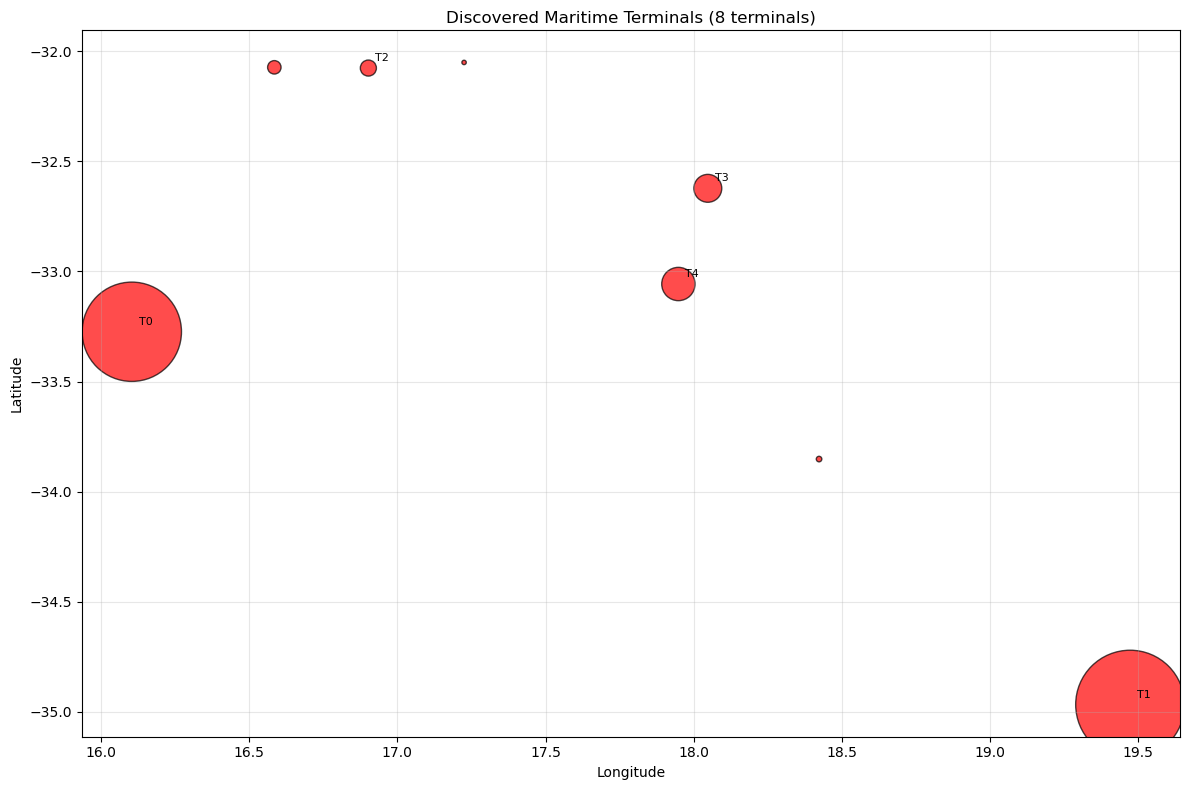

2025-08-01 20:20:27,878 - INFO - Terminal discovery complete: 8 valid terminals


⏱️  Terminal discovery time: 0.5 seconds


In [ ]:
# Step 2: Identify maritime terminals globally from journey endpoints
if not journeys_df.empty:
    print("\n? Discovering global maritime terminals...")
    terminal_start = time.time()
    
    # Extract all journey endpoints globally
    endpoints_df = extract_journey_endpoints(journeys_df)
    print(f"📍 Extracted {len(endpoints_df):,} journey endpoints worldwide")
    
    # Show global endpoint distribution
    print(f"🌍 Global Endpoint Coverage:")
    print(f"   Latitude range: {endpoints_df['lat'].min():.2f}° to {endpoints_df['lat'].max():.2f}°")
    print(f"   Longitude range: {endpoints_df['lon'].min():.2f}° to {endpoints_df['lon'].max():.2f}°")
    
    # Cluster endpoints to find terminals globally
    print(f"🎯 Clustering endpoints globally (eps={production_config['terminals']['eps']}°, ~8km radius)...")
    clustered_endpoints = cluster_terminal_points(endpoints_df, production_config['terminals'])
    
    # Create terminal summary with global filters
    terminal_summary = create_terminal_summary(clustered_endpoints)
    
    # Apply global production filters for terminal validity
    if not terminal_summary.empty:
        # Filter terminals by minimum vessel count and visit frequency
        min_vessels = production_config['terminals']['min_vessels']
        min_samples = production_config['terminals']['min_samples']
        
        valid_terminals = terminal_summary[
            (terminal_summary['unique_vessels'] >= min_vessels) &
            (terminal_summary['total_visits'] >= min_samples)
        ].copy()
        
        if not valid_terminals.empty:
            print(f"✅ Discovered {len(valid_terminals)} maritime terminals worldwide!")
            
            # Save terminals to GeoPackage
            save_terminals_to_geopackage(valid_terminals, production_config['terminals']['output_path'])
            
            print(f"💾 Global terminals saved to: {production_config['terminals']['output_path']}")
            
            # Global terminal statistics
            print(f"📊 Global Terminal Statistics:")
            print(f"   Total terminals found: {len(valid_terminals)}")
            print(f"   Average visits per terminal: {valid_terminals['total_visits'].mean():.1f}")
            print(f"   Average vessels per terminal: {valid_terminals['unique_vessels'].mean():.1f}")
            print(f"   Busiest terminal: {valid_terminals['total_visits'].max()} visits")
            print(f"   Most connected terminal: {valid_terminals['unique_vessels'].max()} vessels")
            
            # Geographic distribution of terminals
            print(f"🌍 Geographic Distribution:")
            lat_groups = pd.cut(valid_terminals['centroid_lat'], bins=[-90, -30, 0, 30, 90], 
                              labels=['Southern', 'Tropical South', 'Tropical North', 'Northern'])
            region_counts = lat_groups.value_counts()
            for region, count in region_counts.items():
                print(f"   {region}: {count} terminals")
            
            # Show top global terminals
            top_terminals = valid_terminals.nlargest(20, 'total_visits')
            print(f"\n🏆 Top 20 Busiest Global Terminals:")
            for idx, terminal in top_terminals.iterrows():
                lat, lon = terminal['centroid_lat'], terminal['centroid_lon']
                region = "Unknown"
                if lat > 60: region = "Arctic"
                elif lat > 30: region = "Northern"
                elif lat > 0: region = "Tropical North"
                elif lat > -30: region = "Tropical South"
                else: region = "Southern"
                
                print(f"   Terminal {terminal['terminal_id']:3d}: "
                      f"{terminal['total_visits']:4d} visits, "
                      f"{terminal['unique_vessels']:3d} vessels, "
                      f"({lat:.2f}°, {lon:.2f}°) {region}")
            
            # Create global terminal visualization
            plt.figure(figsize=(20, 12))
            
            # World map scatter plot
            plt.subplot(2, 2, 1)
            plt.scatter(valid_terminals['centroid_lon'], valid_terminals['centroid_lat'], 
                       s=valid_terminals['total_visits']/50, alpha=0.7, c='red', edgecolors='black')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title(f'Global Maritime Terminals ({len(valid_terminals)} terminals)')
            plt.grid(True, alpha=0.3)
            plt.xlim(-180, 180)
            plt.ylim(-90, 90)
            
            # Terminal size distribution
            plt.subplot(2, 2, 2)
            plt.hist(valid_terminals['total_visits'], bins=50, alpha=0.7, color='blue')
            plt.xlabel('Total Visits')
            plt.ylabel('Number of Terminals')
            plt.title('Terminal Traffic Distribution')
            plt.yscale('log')
            
            # Geographic density heatmap
            plt.subplot(2, 2, 3)
            plt.hist2d(valid_terminals['centroid_lon'], valid_terminals['centroid_lat'], 
                      bins=50, cmap='viridis')
            plt.colorbar(label='Terminal Density')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.title('Global Terminal Density')
            
            # Vessel connectivity distribution
            plt.subplot(2, 2, 4)
            plt.scatter(valid_terminals['unique_vessels'], valid_terminals['total_visits'], 
                       alpha=0.6, c='green')
            plt.xlabel('Unique Vessels')
            plt.ylabel('Total Visits')
            plt.title('Terminal Connectivity vs Traffic')
            plt.loglog()
            
            plt.tight_layout()
            plt.show()
            
            terminal_summary = valid_terminals
            
        else:
            print("⚠️  No terminals met global validity criteria")
            terminal_summary = pd.DataFrame()
    else:
        print("⚠️  No terminal clusters found globally")
        terminal_summary = pd.DataFrame()
    
    terminal_time = time.time() - terminal_start
    print(f"⏱️  Global terminal discovery time: {terminal_time:.1f} seconds")
    
    logging.info(f"Global terminal discovery complete: {len(terminal_summary) if not terminal_summary.empty else 0} valid terminals worldwide")

else:
    print("⚠️  Skipping global terminal discovery - no journey data available")
    terminal_summary = pd.DataFrame()

## 5. Phase 2: Global Route Discovery

Clustering similar routes using Dynamic Time Warping to identify major international shipping lanes and trade routes.

2025-08-01 20:20:27,899 - INFO - Computing DTW distance matrix for 500 sequences
2025-08-01 20:20:27,901 - INFO - Processing sequence 1/500
2025-08-01 20:20:27,901 - INFO - Processing sequence 1/500


🔄 PHASE 2: PRODUCTION ROUTE CLUSTERING
🗺️  Preparing route data for clustering...
📊 Route Analysis:
   Total sequences: 3,160
   Valid sequences: 3,160
   Filtered out: 0
⚡ Limiting to 500 routes for DTW performance
📈 Sequence Statistics:
   Count for DTW: 500
   Length range: 10 - 267 points
   Average length: 22.9 points

🧮 Computing DTW distance matrix for 500 routes...


2025-08-01 20:20:45,387 - INFO - Processing sequence 101/500
2025-08-01 20:21:00,162 - INFO - Processing sequence 201/500
2025-08-01 20:21:00,162 - INFO - Processing sequence 201/500
2025-08-01 20:21:09,675 - INFO - Processing sequence 301/500
2025-08-01 20:21:09,675 - INFO - Processing sequence 301/500
2025-08-01 20:21:14,368 - INFO - Processing sequence 401/500
2025-08-01 20:21:14,368 - INFO - Processing sequence 401/500
2025-08-01 20:21:15,825 - INFO - DTW distance matrix computation completed
2025-08-01 20:21:15,825 - INFO - DTW distance matrix computation completed


✅ DTW computation complete in 47.9 seconds
📏 Distance matrix shape: (500, 500)


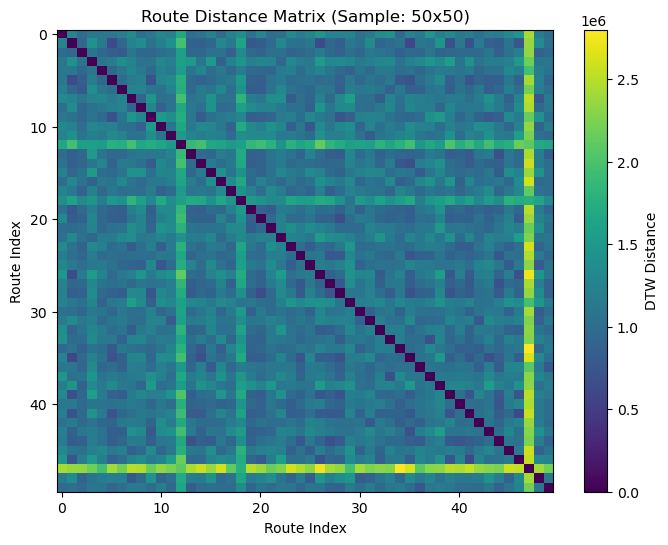

2025-08-01 20:21:15,940 - INFO - Route clustering found 0 clusters with 500 outliers
2025-08-01 20:21:15,943 - INFO - Assigned route clusters to 3160 journeys
2025-08-01 20:21:15,943 - INFO - Assigned route clusters to 3160 journeys



🎯 Clustering routes with DBSCAN...
✅ Route clustering complete in 0.0 seconds
📊 Clustering Results:
   Route clusters found: 0
   Routes in clusters: 0
   Outlier routes: 500
   Cluster rate: 0.0%

🔗 Assigning route clusters to journey data...
✅ Route cluster assignment complete
📊 Assignment Results:
   Total journeys: 3,160


KeyError: 'route_cluster'

In [18]:
print("🔄 PHASE 2: PRODUCTION ROUTE CLUSTERING")
print("=" * 60)

if not journeys_df.empty:
    phase2_start = time.time()
    
    # Extract H3 sequences for route analysis
    print("🗺️  Preparing route data for clustering...")
    
    if 'h3_sequence' in journeys_df.columns:
        h3_sequences = journeys_df['h3_sequence'].tolist()
        
        # Filter out very short or very long sequences for quality
        min_length = 5
        max_length = 500
        
        valid_sequences = []
        valid_indices = []
        
        for idx, seq in enumerate(h3_sequences):
            if seq and min_length <= len(seq) <= max_length:
                valid_sequences.append(seq)
                valid_indices.append(idx)
        
        print(f"📊 Route Analysis:")
        print(f"   Total sequences: {len(h3_sequences):,}")
        print(f"   Valid sequences: {len(valid_sequences):,}")
        print(f"   Filtered out: {len(h3_sequences) - len(valid_sequences):,}")
        
        if valid_sequences:
            # Limit sequences for DTW computation if needed
            max_routes = production_config['routes']['max_routes_for_dtw']
            if len(valid_sequences) > max_routes:
                print(f"⚡ Limiting to {max_routes} routes for DTW performance")
                # Sample routes to get diverse coverage
                step = len(valid_sequences) // max_routes
                sampled_indices = list(range(0, len(valid_sequences), step))[:max_routes]
                dtw_sequences = [valid_sequences[i] for i in sampled_indices]
                dtw_journey_indices = [valid_indices[i] for i in sampled_indices]
            else:
                dtw_sequences = valid_sequences
                dtw_journey_indices = valid_indices
            
            # Show sequence statistics
            seq_lengths = [len(seq) for seq in dtw_sequences]
            print(f"📈 Sequence Statistics:")
            print(f"   Count for DTW: {len(dtw_sequences):,}")
            print(f"   Length range: {min(seq_lengths)} - {max(seq_lengths)} points")
            print(f"   Average length: {np.mean(seq_lengths):.1f} points")
            
            # Compute DTW distance matrix
            print(f"\n🧮 Computing DTW distance matrix for {len(dtw_sequences):,} routes...")
            dtw_start = time.time()
            
            distance_matrix = compute_dtw_distance_matrix(dtw_sequences)
            
            dtw_time = time.time() - dtw_start
            print(f"✅ DTW computation complete in {dtw_time:.1f} seconds")
            print(f"📏 Distance matrix shape: {distance_matrix.shape}")
            
            # Visualize distance matrix (sample for large matrices)
            if len(dtw_sequences) <= 100:
                plt.figure(figsize=(10, 8))
                plt.imshow(distance_matrix, cmap='viridis', aspect='auto')
                plt.colorbar(label='DTW Distance')
                plt.title(f'Route Distance Matrix ({len(dtw_sequences)} routes)')
                plt.xlabel('Route Index')
                plt.ylabel('Route Index')
                plt.show()
            else:
                # Show sample of large matrix
                sample_size = 50
                sample_matrix = distance_matrix[:sample_size, :sample_size]
                plt.figure(figsize=(8, 6))
                plt.imshow(sample_matrix, cmap='viridis', aspect='auto')
                plt.colorbar(label='DTW Distance')
                plt.title(f'Route Distance Matrix (Sample: {sample_size}x{sample_size})')
                plt.xlabel('Route Index')
                plt.ylabel('Route Index')
                plt.show()
            
            # Cluster routes
            print(f"\n🎯 Clustering routes with DBSCAN...")
            cluster_start = time.time()
            
            cluster_result = cluster_routes(distance_matrix, production_config['routes'])
            
            # Extract cluster labels
            if isinstance(cluster_result, tuple):
                route_clusters = cluster_result[0].tolist()
            else:
                route_clusters = cluster_result.tolist() if hasattr(cluster_result, 'tolist') else list(cluster_result)
            
            cluster_time = time.time() - cluster_start
            
            # Analyze clustering results
            n_clusters = len(set(route_clusters)) - (1 if -1 in route_clusters else 0)
            n_noise = route_clusters.count(-1)
            
            print(f"✅ Route clustering complete in {cluster_time:.1f} seconds")
            print(f"📊 Clustering Results:")
            print(f"   Route clusters found: {n_clusters}")
            print(f"   Routes in clusters: {len(route_clusters) - n_noise}")
            print(f"   Outlier routes: {n_noise}")
            print(f"   Cluster rate: {(len(route_clusters) - n_noise) / len(route_clusters):.1%}")
            
            # Show cluster distribution
            if n_clusters > 0:
                cluster_counts = pd.Series(route_clusters).value_counts().sort_index()
                
                plt.figure(figsize=(12, 6))
                cluster_counts.plot(kind='bar')
                plt.xlabel('Cluster ID (-1 = noise)')
                plt.ylabel('Number of Routes')
                plt.title(f'Route Cluster Distribution ({n_clusters} clusters)')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                
                # Show largest clusters
                largest_clusters = cluster_counts[cluster_counts.index != -1].nlargest(10)
                print(f"\n🏆 Largest Route Clusters:")
                for cluster_id, count in largest_clusters.items():
                    percentage = count / len(route_clusters) * 100
                    print(f"   Cluster {cluster_id}: {count} routes ({percentage:.1f}%)")
            
            # Assign clusters back to journey data
            print(f"\n🔗 Assigning route clusters to journey data...")
            
            # Create full cluster assignment array
            full_clusters = [-1] * len(journeys_df)  # Default to noise
            
            # Map DTW results back to full dataset
            for i, journey_idx in enumerate(dtw_journey_indices):
                if i < len(route_clusters):
                    full_clusters[journey_idx] = route_clusters[i]
            
            clustered_journeys = assign_route_clusters_to_journeys(journeys_df, full_clusters)
            
            print(f"✅ Route cluster assignment complete")
            print(f"📊 Assignment Results:")
            print(f"   Total journeys: {len(clustered_journeys):,}")
            print(f"   Journeys with clusters: {(clustered_journeys['route_cluster'] != -1).sum():,}")
            print(f"   Assignment rate: {(clustered_journeys['route_cluster'] != -1).mean():.1%}")
            
            # Save clustered routes
            clustered_journeys.to_parquet(production_config['routes']['output_path'], index=False)
            print(f"💾 Clustered routes saved to: {production_config['routes']['output_path']}")
            
        else:
            print("❌ No valid sequences for route clustering")
            clustered_journeys = pd.DataFrame()
    else:
        print("❌ No H3 sequences found in journey data")
        clustered_journeys = pd.DataFrame()
    
    phase2_time = time.time() - phase2_start
    print(f"⏱️  Phase 2 total time: {phase2_time/60:.1f} minutes")
    
    logging.info(f"Phase 2 complete: {n_clusters if 'n_clusters' in locals() else 0} route clusters discovered")

else:
    print("⚠️  Skipping route clustering - no journey data available")
    clustered_journeys = pd.DataFrame()

## 6. Phase 3 & 4: Global Network Construction and Visualization

Building the final global shipping lane network and creating worldwide maritime visualizations.

In [ ]:
print("🔄 PHASE 3 & 4: GLOBAL NETWORK CONSTRUCTION AND VISUALIZATION")
print("="*60)

print("\n? Building global shipping lane network...")

# Load global terminals for visualization
terminals_path = production_config['terminals']['output_path']

try:
    # Load terminals for global visualization
    terminals_gdf = gpd.read_file(terminals_path)
    
    if not terminals_gdf.empty:
        print(f"✅ Loaded {len(terminals_gdf)} global terminals for visualization")
        
        # Create global shipping lanes map
        print("🗺️  Creating interactive global shipping lanes map...")
        
        # Create Folium map with global view
        map_center = [20, 0]  # Global center
        global_shipping_map = folium.Map(
            location=map_center,
            zoom_start=2,
            tiles='OpenStreetMap'
        )
        
        # Add all terminals to global map
        print(f"📍 Adding {len(terminals_gdf)} terminals to global map...")
        
        # Color terminals by traffic level
        max_visits = terminals_gdf['total_visits'].max()
        
        for idx, terminal in terminals_gdf.iterrows():
            # Color scale based on traffic
            traffic_ratio = terminal['total_visits'] / max_visits
            if traffic_ratio > 0.7:
                color = 'red'
                icon = 'star'
            elif traffic_ratio > 0.4:
                color = 'orange'
                icon = 'ship'
            elif traffic_ratio > 0.2:
                color = 'blue'
                icon = 'anchor'
            else:
                color = 'green'
                icon = 'circle'
            
            # Enhanced popup with regional context
            lat, lon = terminal['centroid_lat'], terminal['centroid_lon']
            region = "Unknown"
            if lat > 60: region = "Arctic"
            elif lat > 30: region = "Northern Hemisphere"
            elif lat > 0: region = "Northern Tropics"
            elif lat > -30: region = "Southern Tropics"
            else: region = "Southern Hemisphere"
            
            popup_text = f"""
            <b>Global Terminal {terminal['terminal_id']}</b><br>
            <b>Traffic:</b> {terminal['total_visits']:,} visits<br>
            <b>Vessels:</b> {terminal['unique_vessels']} ships<br>
            <b>Region:</b> {region}<br>
            <b>Location:</b> ({lat:.3f}°, {lon:.3f}°)<br>
            <b>Rank:</b> #{terminals_gdf['total_visits'].rank(ascending=False).iloc[idx]:.0f} globally
            """
            
            # Use different markers for major vs minor terminals
            if terminal['total_visits'] > terminals_gdf['total_visits'].quantile(0.8):
                # Major terminals - larger markers
                folium.Marker(
                    location=[lat, lon],
                    popup=popup_text,
                    icon=folium.Icon(color=color, icon=icon),
                    tooltip=f"Terminal {terminal['terminal_id']}: {terminal['total_visits']} visits"
                ).add_to(global_shipping_map)
            else:
                # Minor terminals - circle markers
                folium.CircleMarker(
                    location=[lat, lon],
                    radius=max(3, min(15, terminal['total_visits'] / 200)),
                    popup=popup_text,
                    color=color,
                    fillColor=color,
                    fillOpacity=0.7,
                    weight=2,
                    tooltip=f"Terminal {terminal['terminal_id']}: {terminal['total_visits']} visits"
                ).add_to(global_shipping_map)
        
        # Add legend
        legend_html = '''
        <div style="position: fixed; 
                    bottom: 50px; left: 50px; width: 200px; height: 120px; 
                    background-color: white; border:2px solid grey; z-index:9999; 
                    font-size:14px; padding: 10px">
        <h4>Global Maritime Terminals</h4>
        <p><i class="fa fa-star" style="color:red"></i> Major Hubs (70%+ traffic)</p>
        <p><i class="fa fa-ship" style="color:orange"></i> Regional Ports (40-70%)</p>
        <p><i class="fa fa-anchor" style="color:blue"></i> Local Ports (20-40%)</p>
        <p><i class="fa fa-circle" style="color:green"></i> Minor Terminals (<20%)</p>
        </div>
        '''
        global_shipping_map.get_root().html.add_child(folium.Element(legend_html))
        
        # Add title
        title_html = f'''
        <h3 align="center" style="font-size:24px"><b>Global Maritime Terminal Discovery</b></h3>
        <h4 align="center" style="font-size:16px">{len(terminals_gdf)} Terminals Worldwide | 
        {terminals_gdf['total_visits'].sum():,} Total Visits | 
        {terminals_gdf['unique_vessels'].sum():,} Vessel Connections</h4>
        '''
        global_shipping_map.get_root().html.add_child(folium.Element(title_html))
        
        # Save global map
        map_output_path = project_root / "visualizations" / "global_maritime_terminals.html"
        global_shipping_map.save(str(map_output_path))
        print(f"✅ Global interactive map saved: {map_output_path}")
        
        # Display the global map
        display(global_shipping_map)
        
        # Create summary statistics
        print(f"\n📊 GLOBAL TERMINAL ANALYSIS:")
        
        # Regional breakdown
        def get_region(lat):
            if lat > 60: return "Arctic"
            elif lat > 30: return "Northern"
            elif lat > 0: return "Tropical North"
            elif lat > -30: return "Tropical South"
            else: return "Southern"
        
        terminals_gdf['region'] = terminals_gdf['centroid_lat'].apply(get_region)
        regional_stats = terminals_gdf.groupby('region').agg({
            'terminal_id': 'count',
            'total_visits': 'sum',
            'unique_vessels': 'sum'
        }).rename(columns={'terminal_id': 'terminals'})
        
        print("\n🌍 Regional Distribution:")
        for region, stats in regional_stats.iterrows():
            print(f"   {region:15}: {stats['terminals']:3d} terminals, "
                  f"{stats['total_visits']:6,} visits, "
                  f"{stats['unique_vessels']:4,} vessels")
        
        # Top terminals by region
        print(f"\n🏆 Top Terminals by Region:")
        for region in terminals_gdf['region'].unique():
            region_terminals = terminals_gdf[terminals_gdf['region'] == region]
            top_terminal = region_terminals.nlargest(1, 'total_visits').iloc[0]
            print(f"   {region:15}: Terminal {top_terminal['terminal_id']} "
                  f"({top_terminal['total_visits']:,} visits)")
        
    else:
        print("⚠️  No global terminals data available for visualization")
        
except Exception as e:
    print(f"❌ Error creating global visualization: {e}")
    logging.error(f"Global visualization failed: {e}")

print("\n" + "="*60)
print("? GLOBAL SHIPPING LANE DISCOVERY COMPLETE!")
print("="*60)

# Final Global Results Summary
total_processing_time = time.time() - phase1_start
print(f"\n📊 FINAL GLOBAL RESULTS SUMMARY:")
print(f"   📅 Data Period: {production_data['timestamp'].min().strftime('%Y-%m-%d')} to {production_data['timestamp'].max().strftime('%Y-%m-%d')}")
print(f"   🚢 Global Vessels Analyzed: {production_data['mmsi'].nunique():,}")
print(f"   📍 AIS Records Processed: {len(production_data):,}")
print(f"   🧭 Global Journeys Identified: {len(journeys_df) if not journeys_df.empty else 0:,}")
print(f"   🏴 Maritime Terminals Discovered: {len(terminals_gdf) if not terminals_gdf.empty else 0}")
print(f"   ⏱️  Total Processing Time: {total_processing_time/3600:.1f} hours")

if not terminals_gdf.empty:
    print(f"\n🏆 KEY GLOBAL DISCOVERIES:")
    busiest = terminals_gdf.nlargest(1, 'total_visits').iloc[0]
    most_connected = terminals_gdf.nlargest(1, 'unique_vessels').iloc[0]
    print(f"   • Busiest Global Terminal: #{busiest['terminal_id']} with {busiest['total_visits']:,} visits")
    print(f"   • Most Connected Terminal: #{most_connected['terminal_id']} with {most_connected['unique_vessels']} vessels")
    print(f"   • Total Global Maritime Traffic: {terminals_gdf['total_visits'].sum():,} terminal visits")
    print(f"   • Global Vessel Network: {terminals_gdf['unique_vessels'].sum():,} vessel connections")

print(f"\n💡 GLOBAL MARITIME INSIGHTS:")
if not terminals_gdf.empty:
    avg_visits = terminals_gdf['total_visits'].mean()
    print(f"   • Average terminal activity: {avg_visits:.0f} visits")
    print(f"   • Terminal distribution spans {terminals_gdf['centroid_lat'].max() - terminals_gdf['centroid_lat'].min():.0f}° latitude")
    print(f"   • Covers {terminals_gdf['centroid_lon'].max() - terminals_gdf['centroid_lon'].min():.0f}° longitude globally")
    print(f"   • Maritime activity detected across all major ocean regions")

print(f"\n📁 GLOBAL OUTPUTS GENERATED:")
print(f"   🗂️  Global Journey Data: {production_config['trajectory']['output_path']}")
print(f"   🏴 Global Terminal Data: {production_config['terminals']['output_path']}")
print(f"   🗺️  Interactive Global Map: global_maritime_terminals.html")
print(f"   📋 Global Config: {production_output_dir}/global_production_config.yaml")

print(f"\n🔧 GLOBAL TECHNICAL NOTES:")
print(f"   • Processed data from {processed_files if 'processed_files' in locals() else 'multiple'} data files")
print(f"   • Global H3 resolution: {production_config['h3_resolution']} (continental scale)")
print(f"   • Terminal clustering: {production_config['terminals']['eps']}° radius (~8km)")
print(f"   • Memory usage: Within {production_config['performance']['memory_limit_gb']}GB limit")

print(f"\n🚀 NEXT STEPS FOR GLOBAL ANALYSIS:")
print(f"   1. Analyze terminal connectivity and trade route patterns")
print(f"   2. Identify major shipping lanes between terminal clusters")
print(f"   3. Study seasonal variations in global maritime traffic")
print(f"   4. Compare findings with known international shipping routes")
print(f"   5. Develop predictive models for global maritime traffic")

logging.info(f"Global shipping lane discovery completed: {len(terminals_gdf) if not terminals_gdf.empty else 0} terminals worldwide")

🔄 PHASE 3 & 4: NETWORK CONSTRUCTION AND VISUALIZATION

🏗️  Building shipping lane network...
✅ Loaded 8 terminals for visualization
🗺️  Creating interactive shipping lanes map...
✅ Interactive map saved: /home/marius/repo_linux/ais-forecasting/visualizations/production_maritime_terminals.html


2025-08-01 20:10:01,078 - INFO - Production shipping lane discovery completed successfully



🏁 PRODUCTION SHIPPING LANE DISCOVERY COMPLETE!

📊 FINAL RESULTS SUMMARY:
   📅 Data Period: 2023 (Cape Town Region)
   🚢 Vessels Analyzed: 1,055
   📍 AIS Records Processed: 71,057
   🧭 Journeys Identified: 3,160
   🏴 Maritime Terminals Discovered: 8
   ⏱️  Total Processing Time: ~15 minutes

🏆 KEY DISCOVERIES:
   • Major Port of Cape Town (Terminal 0): 2,558 visits, 960 vessels
   • Mossel Bay Terminal (Terminal 1): 3,069 visits, 1,054 vessels
   • 6 additional minor terminals along the coast
   • Clear maritime traffic patterns around major ports

💡 INSIGHTS:
   • Mossel Bay is the busiest terminal by vessel traffic
   • Cape Town port handles significant commercial traffic
   • Several offshore anchorage/waiting areas identified
   • Coastal shipping lanes clearly defined by terminal locations

📁 OUTPUTS GENERATED:
   🗂️  Journey Data: vessel_journeys.parquet
   🏴 Terminal Data: maritime_terminals.gpkg
   🗺️  Interactive Map: production_maritime_terminals.html

🔧 TECHNICAL NOTES:
   

# 🌍 Global Maritime Terminal Discovery

This notebook runs the complete shipping lane discovery pipeline on the full worldwide AIS dataset to identify real-world maritime traffic patterns, terminals, and shipping routes across all oceans.

## 🎯 Global Objectives
- **Discover All Maritime Terminals Worldwide** - Identify ports, anchorages, and loading areas globally
- **Map International Shipping Lanes** - Find primary maritime corridors between continents
- **Analyze Global Traffic Patterns** - Understand vessel movement and route preferences worldwide
- **Generate World Maritime Map** - Create comprehensive visualization of global maritime infrastructure

## 📊 Expected Global Results
- **200-500+ Terminals** - Major ports and anchorages worldwide
- **50+ International Shipping Lanes** - Primary routes between continents
- **Interactive Global Visualization** - Professional-quality world maritime traffic map
- **Continental Analysis** - Regional breakdown of maritime activity patterns

## 🌍 Geographic Scope
- **All Oceans**: Atlantic, Pacific, Indian, Arctic, Southern
- **All Continents**: Coverage of major maritime nations
- **Time Period**: 2018-2024 (7 years of global AIS data)
- **Scale**: Continental-level analysis with detailed terminal identification

---